<a href="https://colab.research.google.com/github/cegildersleeve/IEEE-Fraud-Dection-Competition/blob/master/IEEE_Fraud_Detection_Modeling_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import warnings

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score,  accuracy_score, roc_auc_score
from sklearn.decomposition import PCA


In [0]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


In [0]:
import xgboost as xgb

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')


In [0]:
!pip install kaggle


In [0]:
import kaggle

In [0]:
import json

In [0]:
token = {"username":"cgilder","key":"ea25f2cc5279df414150151e2e7da031"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json


In [0]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json


In [0]:
!kaggle datasets list


ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
new-york-state/nys-environmental-remediation-sites          NYS Environmental Remediation Sites                   5MB  2019-08-10 08:20:06           2252  
eliasdabbas/search-engine-results-flights-tickets-keywords  Search Engine Results - Flights & Tickets Keywords   22MB  2019-08-01 11:51:13           1650  
google/google-landmarks-dataset                             Google-Landmarks Dataset                            107MB  2019-08-10 12:00:23          10938  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-08-04 22:04:44           6436  
AnalyzeBoston/crimes-in-boston                              Crim

In [0]:
!kaggle competitions download -c ieee-fraud-detection -p /content

 90% 47.0M/52.5M [00:00<00:00, 134MB/s]
100% 52.5M/52.5M [00:00<00:00, 148MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.1MB/s]
 59% 28.0M/47.3M [00:00<00:00, 102MB/s] 
100% 47.3M/47.3M [00:00<00:00, 156MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 200MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]


In [0]:
!unzip \*.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

5 archives were successfully processed.


In [0]:
test_transaction = pd.read_csv(r'/content/test_transaction.csv')

In [0]:
real_train_transaction = pd.read_csv(r'/content/train_transaction.csv')

In [0]:
train_transaction = pd.read_csv(r'/content/train_transaction_resampled.csv')


## Feature Engineering

To prep the data for modeling I am planning to:

1. Remove columns that have too many nulls
2. Convert the TransactionsDT values from seconds to hours, day of week, and month
3. Convert categorical/object values to 0 or 1
4. log transform skewed numerical data
5. Drop or combine variables with high colinearity
6. Replace coded NaN values and impute values for NaN and similar data

Long term
- Explore clustering data
- Explore using PCA
- Explore creating new values with random adjustments like in https://www.kaggle.com/artgor/eda-and-models
- Explore using if statements, different imputation methods for handling missing values, and NaN agnostic models
- Explore removing Transaction Amount Outlier from Model

### Defining Necessary Functions

In [0]:
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """Creates a day of the week feature, encoded as 0-6. Offset in days to shift the start/end of a day. 
    tname is the time value field and defaults to 'TransactionDT' """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """ Creates an hour of the day feature, encoded as 0-23. """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours
    

In [0]:
def check_percent_fraud(var, df=train_transaction, y='isFraud'):
    percent_fraud = (train_transaction.groupby([var]).sum().isFraud)/(train_transaction.groupby([var]).count()[y])
    count = train_transaction.groupby([var]).count()[y]
    percent_fraud = pd.concat([percent_fraud, count], axis=1)
    percent_fraud.columns = ['Percent','Count']
    percent_fraud = percent_fraud.sort_values(by='Percent',ascending=False)
    return percent_fraud

### Transaction Time Delta, Amount, & ProductCD

We already updated time to include hour, day, and month for data exploration, so I am going to leave those as is.

In [0]:
train_transaction['day_of_week'] = make_day_feature(train_transaction, offset=.58)
train_transaction['hour_of_day'] = make_hour_feature(train_transaction)

In [0]:
#transaction amount is skewed heavily towards smaller amounts, so I am going to apply a log transformation on it
train_transaction.TransactionAmt = train_transaction.TransactionAmt.apply(lambda x: np.log(x+1))

In [0]:
product_dummies = pd.get_dummies(train_transaction['ProductCD'])
train_transaction.drop(columns=['ProductCD'], inplace=True)
train_transaction = pd.concat([train_transaction, product_dummies], axis=1)

### Address, Distribution, Card Columns, & Email

In [0]:
train_transaction = train_transaction.drop(columns=['addr1', 'addr2'])

In [0]:
train_transaction.dist1 = train_transaction.dist1.apply(lambda x: np.log(x))
train_transaction.dist2 = train_transaction.dist2.apply(lambda x: np.log(x))
train_transaction = train_transaction.drop(columns=['dist1', 'dist2'])

In [0]:
card_columns = [x for x in train_transaction.columns.tolist() if 'card' in x]

In [0]:
card_numerical = [x for x in card_columns if train_transaction[x].dtype in ['float64','int64']]
card_categorical = [x for x in card_columns if train_transaction[x].dtype not in ['float64','int64']]


In [0]:
for col in ['card1', 'card2']:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mean())

for col in ['card3', 'card5']:
        train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mode()[0])


In [0]:
card_dummies = pd.get_dummies(train_transaction[card_categorical])
card_dummies_to_drop = ['card6_charge card', 'card6_debit or credit', 'card4_visa', 'card4_mastercard', 'card4_american express']

card_dummies.drop(columns=card_dummies_to_drop, inplace=True)

train_transaction = train_transaction.drop(columns=card_categorical)

train_transaction = pd.concat([train_transaction, card_dummies], axis=1)

In [0]:
train_transaction.loc[train_transaction.P_emaildomain.isnull(), 'P_emaildomain'] = train_transaction.loc[train_transaction.P_emaildomain.isnull(), 'R_emaildomain']

In [0]:
train_transaction.P_emaildomain = train_transaction.P_emaildomain.str.split('.', expand=True)[0]

In [0]:
email_percents = check_percent_fraud('P_emaildomain')

In [0]:
highest_fraud_email = [x for x in email_percents.index.tolist() if email_percents.loc[x,:].Percent >= .8]
medium_fraud_email = [x for x in email_percents.index.tolist() if email_percents.loc[x,:].Percent >= .6 and email_percents.loc[x,:].Percent < .8 ]
lower_fraud_email = [x for x in email_percents.index.tolist() if email_percents.loc[x,:].Percent < .6]


In [0]:
train_transaction['highest_fraud_email'] = train_transaction.P_emaildomain.isin(highest_fraud_email).astype(int)
train_transaction['medium_fraud_email'] = train_transaction.P_emaildomain.isin(medium_fraud_email).astype(int)
train_transaction['lower_fraud_email'] = train_transaction.P_emaildomain.isin(lower_fraud_email).astype(int)

In [0]:
train_transaction.drop(columns=['P_emaildomain', 'R_emaildomain'], inplace=True)

In [0]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,day_of_week,hour_of_day,C,H,R,S,W,card4_discover,card6_credit,card6_debit,highest_fraud_email,medium_fraud_email,lower_fraud_email
0,2987203,1,89760,6.100319,18268,583.0,150.0,226.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,374.0,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1
1,2987240,1,90193,3.640162,13413,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### D, C, & M Variables

In [0]:
c_list = [x for x in train_transaction.columns if x[0] == 'C']

In [0]:
train_transaction['C1_'] = train_transaction.C1.map(lambda x: 1 if x >= 3 else 0)
train_transaction['C2_'] = train_transaction.C2.map(lambda x: 1 if x >= 3 else 0)
train_transaction['C4_'] = train_transaction.C4.map(lambda x: 1 if x >= .05 else 0)
train_transaction['C5_'] = train_transaction.C5.map(lambda x: 1 if x >= .05  else 0)
train_transaction['C7_'] = train_transaction.C7.map(lambda x: 1 if x >= 2 else 0)
train_transaction['C8_'] = train_transaction.C8.map(lambda x: 1 if x >= .05 else 0)
train_transaction['C9_'] = train_transaction.C9.map(lambda x: 1 if x >= .05 else 0)
train_transaction['C10_'] = train_transaction.C10.map(lambda x: 1 if x >= .05 -2.5 else 0)
train_transaction['C11_'] = train_transaction.C11.map(lambda x: 1 if x >= 2 else 0)
train_transaction['C12_'] = train_transaction.C12.map(lambda x: 1 if x >= .05 else 0)
train_transaction['C13_'] = train_transaction.C13.map(lambda x: 1 if x >= .05 else 0)
train_transaction['C14_'] = train_transaction.C14.map(lambda x: 1 if x >= .05 else 0)

In [0]:
c_list_to_drop = ['C3','C6']

In [0]:
train_transaction.drop(columns=c_list_to_drop, inplace=True)

In [0]:
m_list = [x for x in train_transaction.columns if x[0] == 'M']

In [0]:
m_dummies = pd.get_dummies(train_transaction[m_list], dummy_na=True)
m_dummies_to_drop = ['M2_nan', 'M3_nan', 'M8_nan','M9_nan']
m_dummies = m_dummies.drop(columns=m_dummies_to_drop)
train_transaction = train_transaction.drop(columns=m_list)
train_transaction = pd.concat([train_transaction, m_dummies], axis=1)

In [0]:
m_list_to_drop = ['M2_F', 'M3_F', 'M4_M0', 'M4_M1', 'M5_F', 'M5_T', 'M5_nan', 'M7_T', 'M9_F']

In [0]:
m_list = [x for x in train_transaction.columns if x[0] == 'M']

In [0]:
d_list = [x for x in train_transaction.columns if x[0] == 'D']

In [0]:
train_transaction.loc[:,d_list] = train_transaction.loc[:,d_list].fillna(0)

In [0]:
train_transaction['D1_'] = train_transaction.D1.map(lambda x: 1 if x >= 20 else 0)
train_transaction['D2_'] = train_transaction.D2.map(lambda x: 1 if x >= 35 else 0)
train_transaction['D3_'] = train_transaction.D3.map(lambda x: 1 if x >= 4 else 0)
train_transaction['D4_'] = train_transaction.D4.map(lambda x: 1 if x >= 35 else 0)
train_transaction['D5_'] = train_transaction.D5.map(lambda x: 1 if x >= 2  else 0)
train_transaction['D7_'] = train_transaction.D7.map(lambda x: 1 if x >= 20 else 0)
train_transaction['D8_'] = train_transaction.D8.map(lambda x: 1 if x >= 20 else 0)
train_transaction['D9_'] = train_transaction.D9.map(lambda x: 1 if (x >= 0.01 and x <= .4) else 0)
train_transaction['D9__'] = train_transaction.D9.map(lambda x: 1 if (x >= .4 and x <= .8) else 0)
train_transaction['D10_'] = train_transaction.D10.map(lambda x: 1 if x >= 15 -2.5 else 0)
train_transaction['D11_'] = train_transaction.D11.map(lambda x: 1 if x >= 75 else 0)
train_transaction['D15_'] = train_transaction.D15.map(lambda x: 1 if x >= 35 else 0)

In [0]:
d_list_to_drop = ['D6', 'D12', 'D13','D14']

In [0]:
train_transaction.drop(columns=d_list_to_drop, inplace=True)

### V Variables

In [0]:
v_list = [x for x in train_transaction.columns if (x[0] == 'V' and '-' not in x)]

In [0]:
print('Percent Null for V Variables:')
for col in v_list:
    print(col,'is {}% Percent Null'.format(train_transaction[col].isna().sum()/train_transaction.shape[0]*100))

Percent Null for V Variables:
V1 is 58.616851376857184% Percent Null
V2 is 58.616851376857184% Percent Null
V3 is 58.616851376857184% Percent Null
V4 is 58.616851376857184% Percent Null
V5 is 58.616851376857184% Percent Null
V6 is 58.616851376857184% Percent Null
V7 is 58.616851376857184% Percent Null
V8 is 58.616851376857184% Percent Null
V9 is 58.616851376857184% Percent Null
V10 is 58.616851376857184% Percent Null
V11 is 58.616851376857184% Percent Null
V12 is 15.871364274306732% Percent Null
V13 is 15.871364274306732% Percent Null
V14 is 15.871364274306732% Percent Null
V15 is 15.871364274306732% Percent Null
V16 is 15.871364274306732% Percent Null
V17 is 15.871364274306732% Percent Null
V18 is 15.871364274306732% Percent Null
V19 is 15.871364274306732% Percent Null
V20 is 15.871364274306732% Percent Null
V21 is 15.871364274306732% Percent Null
V22 is 15.871364274306732% Percent Null
V23 is 15.871364274306732% Percent Null
V24 is 15.871364274306732% Percent Null
V25 is 15.871364274

In [0]:
null_percents = [(train_transaction[col].isna().sum()/train_transaction.shape[0]*100) for col in v_list]

null_uniques = []
for col in null_percents:
    if col not in null_uniques:
        null_uniques.append(col)

In [0]:
v_group1 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[0]]
v_group2 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[1]]
v_group3 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[2]]
v_group4 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[3]]
v_group5 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[4]]
v_group6 = [col for col in v_list if (train_transaction[col].isna().sum()/train_transaction.shape[0]*100) == null_uniques[5]]

In [0]:
train_transaction['v_group1_nan'] = train_transaction[v_group1[0]].isnull().astype(int)
train_transaction['v_group2_nan'] = train_transaction[v_group2[0]].isnull().astype(int)
train_transaction['v_group3_nan'] = train_transaction[v_group3[0]].isnull().astype(int)
train_transaction['v_group4_nan'] = train_transaction[v_group4[0]].isnull().astype(int)
train_transaction['v_group5_nan'] = train_transaction[v_group5[0]].isnull().astype(int)
train_transaction['v_group6_nan'] = train_transaction[v_group6[0]].isnull().astype(int)

In [0]:
train_transaction['V10_'] = train_transaction.V11.map(lambda x: 1 if x >= .05 else 0)
train_transaction['V11_'] = train_transaction.V15.map(lambda x: 1 if x >= .05 else 0)

In [0]:
train_transaction['V12_'] = train_transaction.V12.map(lambda x: 1 if (x >= .5 and x <= 1.5) else 0)
train_transaction['V13_'] = train_transaction.V13.map(lambda x: 1 if (x >= 1 and x <= 1.5) else 0)
train_transaction['V15_'] = train_transaction.V14.map(lambda x: 1 if (x >= .5 ) else 0)
train_transaction['V16_'] = train_transaction.V14.map(lambda x: 1 if (x >= .5) else 0)
train_transaction['V18_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V21_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V22_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V29_'] = train_transaction.V13.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
train_transaction['V29_'] = train_transaction.V13.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
train_transaction['V30_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V31_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V32_'] = train_transaction.V14.map(lambda x: 1 if (x > 0.5) else 0)
train_transaction['V33_'] = train_transaction.V14.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V34_'] = train_transaction.V14.map(lambda x: 1 if (x >= 0.5) else 0)

In [0]:
train_transaction['V35_'] = train_transaction.V35.map(lambda x: 1 if (x >= .5) else 0)
train_transaction['V36_'] = train_transaction.V36.map(lambda x: 1 if (x >= .5) else 0)
train_transaction['V39_'] = train_transaction.V39.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V40_'] = train_transaction.V40.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V40_'] = train_transaction.V40.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V40_'] = train_transaction.V40.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V39_'] = train_transaction.V39.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V42_'] = train_transaction.V42.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V43_'] = train_transaction.V43.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V44_'] = train_transaction.V44.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V45_'] = train_transaction.V45.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V48_'] = train_transaction.V48.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V49_'] = train_transaction.V49.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
train_transaction['V49_'] = train_transaction.V49.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
train_transaction['V50_'] = train_transaction.V50.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
train_transaction['V51_'] = train_transaction.V51.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
train_transaction['V52_'] = train_transaction.V52.map(lambda x: 1 if (x == 0) else 0)

In [0]:
train_transaction['V53_'] = train_transaction.V53.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V54_'] = train_transaction.V54.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V57_'] = train_transaction.V57.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V58_'] = train_transaction.V58.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V59_'] = train_transaction.V59.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
train_transaction['V63_'] = train_transaction.V63.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V64_'] = train_transaction.V64.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V70_'] = train_transaction.V70.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V71_'] = train_transaction.V71.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
train_transaction['V72_'] = train_transaction.V72.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V73_'] = train_transaction.V73.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V74_'] = train_transaction.V74.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)

In [0]:
train_transaction['V75_'] = train_transaction.V75.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V76_'] = train_transaction.V76.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V78_'] = train_transaction.V78.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
train_transaction['V79_'] = train_transaction.V79.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
train_transaction['V80_'] = train_transaction.V80.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
train_transaction['V81_'] = train_transaction.V81.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
train_transaction['V84_'] = train_transaction.V84.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V85_'] = train_transaction.V85.map(lambda x: 1 if (x >= .5) else 0)
train_transaction['V86_'] = train_transaction.V86.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
train_transaction['V90_'] = train_transaction.V90.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
train_transaction['V91_'] = train_transaction.V91.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V92_'] = train_transaction.V92.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V93_'] = train_transaction.V93.map(lambda x: 1 if (x == 0) else 0)
train_transaction['V94_'] = train_transaction.V94.map(lambda x: 1 if (x == 0) else 0)



In [0]:
train_transaction.drop(columns = v_list, inplace=True)

In [0]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C4,C5,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D7,D8,D9,D10,D11,D15,day_of_week,hour_of_day,C,H,R,S,W,card4_discover,card6_credit,card6_debit,highest_fraud_email,medium_fraud_email,lower_fraud_email,C1_,C2_,C4_,C5_,C7_,C8_,C9_,C10_,C11_,C12_,C13_,C14_,M1_T,M1_nan,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M9_F,M9_T,D1_,D2_,D3_,D4_,D5_,D7_,D8_,D9_,D9__,D10_,D11_,D15_,v_group1_nan,v_group2_nan,v_group3_nan,v_group4_nan,v_group5_nan,v_group6_nan,V10_,V11_,V12_,V13_,V15_,V16_,V18_,V21_,V22_,V29_,V30_,V31_,V32_,V33_,V34_,V35_,V36_,V39_,V40_,V42_,V43_,V44_,V45_,V48_,V49_,V50_,V51_,V52_,V53_,V54_,V57_,V58_,V59_,V63_,V64_,V70_,V71_,V72_,V73_,V74_,V75_,V76_,V78_,V79_,V80_,V81_,V84_,V85_,V86_,V90_,V91_,V92_,V93_,V94_
0,2987203,1,89760,6.100319,18268,583.0,150.0,226.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,0.0,0.0,0.000000,0.000000,80.0,0.0,374.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,0,1,0,1,1,1,1
1,2987240,1,90193,3.640162,13413,103.0,185.0,137.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,0
2,2987243,1,90246,3.640162,13413,103.0,185.0,137.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,1,1,1,0,1,0,0,1,0,0,0
3,2987245,1,90295,3.640162,13413,103.0,185.0,137.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.041664,0.041666,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,1,1,1,0,1,0,0,1,0,0,0
4,2987288,1,90986,5.053190,16578,545.0,185.0,226.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,1,1,1,0,1,1,0,1,0,0,0


In [0]:
Y_train = train_transaction.isFraud

In [0]:
train_transaction.drop(columns=['TransactionID','isFraud', 'TransactionDT'],inplace=True)

### Prepare Validation Data

In [0]:
def clean_transaction_data(df):   
    df['day_of_week'] = make_day_feature(df, offset=.58)
    df['hour_of_day'] = make_hour_feature(df)

    #transaction amount is skewed heavily towards smaller amounts, so I am going to apply a log transformation on it
    df.TransactionAmt = df.TransactionAmt.apply(lambda x: np.log(x+1))

    product_dummies = pd.get_dummies(df['ProductCD'])
    df.drop(columns=['ProductCD'], inplace=True)
    df = pd.concat([df, product_dummies], axis=1)

    ### Address, Distribution, Card Columns, & Email

    df = df.drop(columns=['addr1', 'addr2'])

    df.dist1 = df.dist1.apply(lambda x: np.log(x))
    df.dist2 = df.dist2.apply(lambda x: np.log(x))
    df = df.drop(columns=['dist1', 'dist2'])


    card_columns = [x for x in df.columns.tolist() if 'card' in x]

    card_numerical = [x for x in card_columns if df[x].dtype in ['float64','int64']]
    card_categorical = [x for x in card_columns if df[x].dtype not in ['float64','int64']]
    
    for col in ['card1', 'card2']:
        df[col] = df[col].fillna(df[col].mean())

    for col in ['card3', 'card5']:
        df[col] = df[col].fillna(df[col].mode()[0])

    card_dummies = pd.get_dummies(df[card_categorical])

    card_dummies_to_drop = ['card6_charge card', 'card4_visa', 'card4_mastercard', 'card4_american express']

    card_dummies.drop(columns=card_dummies_to_drop, inplace=True)

    df = df.drop(columns=card_categorical)

    df = pd.concat([df, card_dummies], axis=1)

    df.loc[df.P_emaildomain.isnull(), 'P_emaildomain'] = df.loc[df.P_emaildomain.isnull(), 'R_emaildomain']

    df.P_emaildomain = df.P_emaildomain.str.split('.', expand=True)[0]

    df['highest_fraud_email'] = df.P_emaildomain.isin(highest_fraud_email).astype(int)
    df['medium_fraud_email'] = df.P_emaildomain.isin(medium_fraud_email).astype(int)
    df['lower_fraud_email'] = df.P_emaildomain.isin(lower_fraud_email).astype(int)

    df.drop(columns=['P_emaildomain', 'R_emaildomain'], inplace=True)

    ### D, C, & M Variables

    c_list = [x for x in df.columns if x[0] == 'C']

    df['C1_'] = df.C1.map(lambda x: 1 if x >= 3 else 0)
    df['C2_'] = df.C2.map(lambda x: 1 if x >= 3 else 0)
    df['C4_'] = df.C4.map(lambda x: 1 if x >= .05 else 0)
    df['C5_'] = df.C5.map(lambda x: 1 if x >= .05  else 0)
    df['C7_'] = df.C7.map(lambda x: 1 if x >= 2 else 0)
    df['C8_'] = df.C8.map(lambda x: 1 if x >= .05 else 0)
    df['C9_'] = df.C9.map(lambda x: 1 if x >= .05 else 0)
    df['C10_'] = df.C10.map(lambda x: 1 if x >= .05 -2.5 else 0)
    df['C11_'] = df.C11.map(lambda x: 1 if x >= 2 else 0)
    df['C12_'] = df.C12.map(lambda x: 1 if x >= .05 else 0)
    df['C13_'] = df.C13.map(lambda x: 1 if x >= .05 else 0)
    df['C14_'] = df.C14.map(lambda x: 1 if x >= .05 else 0)

    for col in c_list:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    c_list_to_drop = ['C3','C6']

    df.drop(columns=c_list_to_drop, inplace=True)

    m_list = [x for x in df.columns if x[0] == 'M']

    m_dummies = pd.get_dummies(df[m_list], dummy_na=True)
    m_dummies_to_drop = ['M2_nan', 'M3_nan', 'M8_nan','M9_nan']
    m_dummies = m_dummies.drop(columns=m_dummies_to_drop)
    df = df.drop(columns=m_list)
    df = pd.concat([df, m_dummies], axis=1)

    m_list_to_drop = ['M2_F', 'M3_F', 'M4_M0', 'M4_M1', 'M5_F', 'M5_T', 'M5_nan', 'M7_T', 'M9_F']

    m_list = [x for x in df.columns if x[0] == 'M']

    df.loc[:,d_list] = df.loc[:,d_list].fillna(0)

    df['D1_'] = df.D1.map(lambda x: 1 if x >= 20 else 0)
    df['D2_'] = df.D2.map(lambda x: 1 if x >= 35 else 0)
    df['D3_'] = df.D3.map(lambda x: 1 if x >= 4 else 0)
    df['D4_'] = df.D4.map(lambda x: 1 if x >= 35 else 0)
    df['D5_'] = df.D5.map(lambda x: 1 if x >= 2  else 0)
    df['D7_'] = df.D7.map(lambda x: 1 if x >= 20 else 0)
    df['D8_'] = df.D8.map(lambda x: 1 if x >= 20 else 0)
    df['D9_'] = df.D9.map(lambda x: 1 if (x >= 0.01 and x <= .4) else 0)
    df['D9__'] = df.D9.map(lambda x: 1 if (x >= .4 and x <= .8) else 0)
    df['D10_'] = df.D10.map(lambda x: 1 if x >= 15 -2.5 else 0)
    df['D11_'] = df.D11.map(lambda x: 1 if x >= 75 else 0)
    df['D15_'] = df.D15.map(lambda x: 1 if x >= 35 else 0)

    d_list_to_drop = ['D6', 'D12', 'D13','D14']

    df.drop(columns=d_list_to_drop, inplace=True)

    ### V Variables

    v_list = [x for x in df.columns if (x[0] == 'V' and '-' not in x)]

    df['v_group1_nan'] = df[v_group1[0]].isnull().astype(int)
    df['v_group2_nan'] = df[v_group2[0]].isnull().astype(int)
    df['v_group3_nan'] = df[v_group3[0]].isnull().astype(int)
    df['v_group4_nan'] = df[v_group4[0]].isnull().astype(int)
    df['v_group5_nan'] = df[v_group5[0]].isnull().astype(int)
    df['v_group6_nan'] = df[v_group6[0]].isnull().astype(int)

    df['V10_'] = df.V11.map(lambda x: 1 if x >= .05 else 0)
    df['V11_'] = df.V15.map(lambda x: 1 if x >= .05 else 0)

    df['V12_'] = df.V12.map(lambda x: 1 if (x >= .5 and x <= 1.5) else 0)
    df['V13_'] = df.V13.map(lambda x: 1 if (x >= 1 and x <= 1.5) else 0)
    df['V15_'] = df.V14.map(lambda x: 1 if (x >= .5 ) else 0)
    df['V16_'] = df.V14.map(lambda x: 1 if (x >= .5) else 0)
    df['V18_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V21_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V22_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V29_'] = df.V13.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
    df['V29_'] = df.V13.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
    df['V30_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V31_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V32_'] = df.V14.map(lambda x: 1 if (x > 0.5) else 0)
    df['V33_'] = df.V14.map(lambda x: 1 if (x == 0) else 0)
    df['V34_'] = df.V14.map(lambda x: 1 if (x >= 0.5) else 0)

    df['V35_'] = df.V35.map(lambda x: 1 if (x >= .5) else 0)
    df['V36_'] = df.V36.map(lambda x: 1 if (x >= .5) else 0)
    df['V39_'] = df.V39.map(lambda x: 1 if (x == 0) else 0)
    df['V40_'] = df.V40.map(lambda x: 1 if (x == 0) else 0)
    df['V40_'] = df.V40.map(lambda x: 1 if (x == 0) else 0)
    df['V40_'] = df.V40.map(lambda x: 1 if (x == 0) else 0)
    df['V39_'] = df.V39.map(lambda x: 1 if (x == 0) else 0)
    df['V42_'] = df.V42.map(lambda x: 1 if (x == 0) else 0)
    df['V43_'] = df.V43.map(lambda x: 1 if (x == 0) else 0)
    df['V44_'] = df.V44.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V45_'] = df.V45.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V48_'] = df.V48.map(lambda x: 1 if (x == 0) else 0)
    df['V49_'] = df.V49.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
    df['V49_'] = df.V49.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
    df['V50_'] = df.V50.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
    df['V51_'] = df.V51.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
    df['V52_'] = df.V52.map(lambda x: 1 if (x == 0) else 0)

    df['V53_'] = df.V53.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V54_'] = df.V54.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V57_'] = df.V57.map(lambda x: 1 if (x == 0) else 0)
    df['V58_'] = df.V58.map(lambda x: 1 if (x == 0) else 0)
    df['V59_'] = df.V59.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
    df['V63_'] = df.V63.map(lambda x: 1 if (x == 0) else 0)
    df['V64_'] = df.V64.map(lambda x: 1 if (x == 0) else 0)
    df['V70_'] = df.V70.map(lambda x: 1 if (x == 0) else 0)
    df['V71_'] = df.V71.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)
    df['V72_'] = df.V72.map(lambda x: 1 if (x == 0) else 0)
    df['V73_'] = df.V73.map(lambda x: 1 if (x == 0) else 0)
    df['V74_'] = df.V74.map(lambda x: 1 if (x >= .5 and x <= 10) else 0)

    df['V75_'] = df.V75.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V76_'] = df.V76.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V78_'] = df.V78.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
    df['V79_'] = df.V79.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
    df['V80_'] = df.V80.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
    df['V81_'] = df.V81.map(lambda x: 1 if (x >= 0 and x <= 1) else 0)
    df['V84_'] = df.V84.map(lambda x: 1 if (x == 0) else 0)
    df['V85_'] = df.V85.map(lambda x: 1 if (x >= .5) else 0)
    df['V86_'] = df.V86.map(lambda x: 1 if (x >= .5 and x <= 1) else 0)
    df['V90_'] = df.V90.map(lambda x: 1 if (x >= .5 and x <= 2) else 0)
    df['V91_'] = df.V91.map(lambda x: 1 if (x == 0) else 0)
    df['V92_'] = df.V92.map(lambda x: 1 if (x == 0) else 0)
    df['V93_'] = df.V93.map(lambda x: 1 if (x == 0) else 0)
    df['V94_'] = df.V94.map(lambda x: 1 if (x == 0) else 0)
    
    for x in ['card6_debit or credit', 'M1_F']:
        if x in df.columns:
            df.drop(columns = [x], inplace=True)


    df.drop(columns = v_list, inplace=True)

    df.drop(columns=['TransactionID', 'TransactionDT'],inplace=True)
    
    return df

In [0]:
y_validate = real_train_transaction.isFraud

In [0]:
x_validate = clean_transaction_data(real_train_transaction)

In [0]:
x_validate.drop(columns=['isFraud'],inplace=True)

### Scaling Data & Checking Fit

In [0]:
x_train, y_train = train_transaction, Y_train

In [0]:
scaler = StandardScaler()

In [0]:
x_train_scaled = scaler.fit_transform(x_train)

In [0]:
x_validate_scaled = scaler.transform(x_validate)

In [0]:
df_x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

In [0]:
df_x_validate_scaled = pd.DataFrame(x_validate_scaled, columns=x_train.columns)

In [0]:
def visualize_fit(x, y, alpha=.3):
    pca =PCA(n_components=2)
    pca_weights = pca.fit_transform(x)
    pca_weights = pd.DataFrame(pca_weights)
    pca_weights.columns = ['weight_1', 'weight_2']
    pca_df = pd.concat([pca_weights, y], axis=1)
    return sns.scatterplot(x='weight_1', y='weight_2',hue= y, data =pca_df, alpha=alpha )

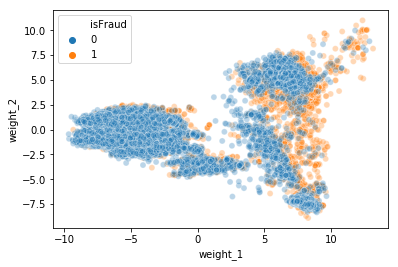

In [0]:
visualize_fit(x_train_scaled, y_train)

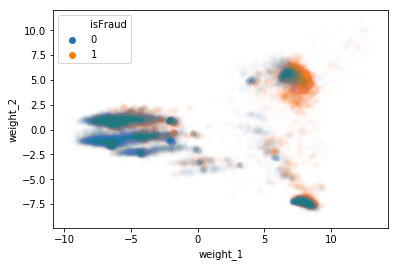

In [0]:
visualize_fit(x_train_scaled, y_train, alpha=.01)

### Initial Modeling with Logistic Regression 

In [0]:
clm = LogisticRegression()

In [0]:
clm.fit(x_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
y_pred = clm.predict(X=x_validate_scaled)

In [0]:
accuracy_score(y_pred, y_validate)

0.8094060803106761

In [0]:
fbeta_score(y_pred=y_pred, y_true=y_validate,beta=2)

0.3814095287516623

In [0]:
y_pred_prob = clm.predict_proba(x_validate_scaled)

In [0]:
y_pred_prob[:,0]

array([0.93396986, 0.63195259, 0.45941982, ..., 0.28485336, 0.88179361,
       0.30722167])

In [0]:
roc_auc_score(y_validate.values, y_pred_prob[:,1])

ValueError: Found input variables with inconsistent numbers of samples: [177162, 506691]

### AdaBoost

In [0]:
clf_B = AdaBoostClassifier(random_state=42)
clf_C = RandomForestClassifier(random_state=42, max_depth=6)

In [0]:
clf_B.fit(x_train_scaled, y_train)
clf_C.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
y_pred_B = clf_B.predict(x_validate_scaled)

In [0]:
accuracy_score(y_pred_B, y_validate)

0.8107212607669816

In [0]:
y_pred_prob_B = clf_B.predict_proba(x_validate_scaled)

In [0]:
roc_auc_score(y_validate.values, y_pred_prob_B[:,1])

0.8634344115799966

In [0]:
y_pred_C = clf_C.predict(x_validate_scaled)

In [0]:
accuracy_score(y_pred_C, y_validate)

0.8469423465528725

In [0]:
y_pred_prob_C = clf_C.predict_proba(x_validate_scaled)

In [0]:
roc_auc_score(y_validate.values, y_pred_prob_C[:,1])

0.8631678228166183

In [0]:
ls = []
for x in range(10, 25, 50):
    ls.append(x)


base_estimator_list = [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4)]

In [0]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

clf = AdaBoostClassifier()

parameters = {'base_estimator': base_estimator_list, 'n_estimators': ls,'learning_rate' : [1] , 'algorithm' : ['SAMME']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)



# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train_scaled, y_train)



# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train_scaled, y_train)).predict_proba(x_validate_scaled)
best_predictions = best_clf.predict_proba(x_validate_scaled)


In [0]:
best_predictions

array([[0.54561219, 0.45438781],
       [0.49961475, 0.50038525],
       [0.53498309, 0.46501691],
       ...,
       [0.47385819, 0.52614181],
       [0.52342507, 0.47657493],
       [0.51046471, 0.48953529]])

In [0]:

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC Score on testing data: {:.4f}".format(roc_auc_score(y_validate, predictions[:,1])))
print("\nOptimized Model\n------")
print("Final ROC score on the testing data: {:.4f}".format(roc_auc_score(y_validate, best_predictions[:,1])))

Unoptimized model
------
ROC Score on testing data: 0.8634

Optimized Model
------
Final ROC score on the testing data: 0.8694


In [0]:
grid_fit.best_params_

{'algorithm': 'SAMME',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1,
 'n_estimators': 10}

### XGBoost


In [0]:
clf_D = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=25,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [0]:
clf_D.fit(x_train_scaled, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [0]:
y_pred = clf_D.predict(x_validate_scaled)

In [0]:
accuracy_score(y_pred, y_validate)

0.9140921868120703

In [0]:
y_pred_prob = clf_D.predict_proba(x_validate_scaled)

In [0]:
y_pred_prob[:,0]

array([0.18732923, 0.8414612 , 0.99010825, ..., 0.97529626, 0.8840354 ,
       0.947242  ], dtype=float32)

In [0]:
roc_auc_score(y_validate.values, y_pred_prob[:,1])

0.9954462004120604

### Prepare Test Data

In [0]:
x_test = clean_transaction_data(test_transaction)

KeyError: ignored

In [0]:
x_test_scaled = scaler.transform(x_test)

In [0]:
y_pred_prob = clf_D.predict_proba(x_test_scaled)

In [0]:
submission = pd.concat([test_transaction.TransactionID, pd.Series(y_pred_prob[:,1])], axis=1)

In [0]:
submission.columns = ['TransactionID','isFraud']

In [0]:
submission.to_csv("ieee-fraud-detection_xgboost.csv", index=False)